In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load QM9 CSV
df = pd.read_csv("datasets/qm9_.csv")

# Subset the data for quick testing
subset_size = 5000  # You can change this to 1000, 10000, etc.
df = df.dropna(subset=["homo", "lumo", "gap", "alpha"]).sample(n=subset_size, random_state=42).reset_index(drop=True)

# Extract SMILES and targets
target_columns = ["homo", "lumo", "gap", "alpha"]
smiles_list = df["smiles"].tolist()
target_props = df[target_columns].values

# Normalize targets
scaler = StandardScaler()
target_props = scaler.fit_transform(target_props)

# Train/test split
train_smiles, test_smiles, train_y, test_y = train_test_split(smiles_list, target_props, test_size=0.2, random_state=42)



FileNotFoundError: [Errno 2] No such file or directory: 'datasets/qm9_.csv'

In [ ]:
class SMILESTokenizer:
    def __init__(self):
        self.special = ['<pad>', '<bos>', '<eos>', '<unk>']
        self.vocab = {tok: idx for idx, tok in enumerate(self.special)}

    def tokenize(self, smiles):
        return list(smiles)

    def build_vocab(self, smiles_list):
        chars = set(c for smi in smiles_list for c in self.tokenize(smi))
        for c in sorted(chars):
            if c not in self.vocab:
                self.vocab[c] = len(self.vocab)

        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, smiles, max_len=128):
        tokens = self.tokenize(smiles)
        ids = [self.vocab.get(tok, self.vocab['<unk>']) for tok in tokens]
        ids = [self.vocab['<bos>']] + ids[:max_len-2] + [self.vocab['<eos>']]
        ids += [self.vocab['<pad>']] * (max_len - len(ids))
        return torch.tensor(ids)

    def vocab_size(self):
        return len(self.vocab)

tokenizer = SMILESTokenizer()
tokenizer.build_vocab(train_smiles + test_smiles)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class QM9Dataset(Dataset):
    def __init__(self, smiles, targets, tokenizer):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = self.tokenizer.encode(self.smiles[idx])
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

train_dataset = QM9Dataset(train_smiles, train_y, tokenizer)
test_dataset = QM9Dataset(test_smiles, test_y, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
import torch.nn as nn

class TransformerRegressor(nn.Module):
    def __init__(self, vocab_size, seq_len, dim=256, heads=16, depth=6, ff_mult=2, n_outputs=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 8)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, 8))
        self.proj = nn.Linear(8, dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=ff_mult*dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.ReLU(),
            nn.Linear(dim // 2, n_outputs)
        )

    def forward(self, x):
        x = self.embed(x) + self.pos_embed[:, :x.size(1), :]
        x = self.proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # average pooling
        return self.head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(tokenizer.vocab_size(), seq_len=128).to(device)

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

100%|██████████| 63/63 [01:29<00:00,  1.42s/it]


Epoch 1 | Loss: 0.9879


100%|██████████| 63/63 [01:31<00:00,  1.46s/it]


Epoch 2 | Loss: 0.7773


100%|██████████| 63/63 [01:27<00:00,  1.39s/it]


Epoch 3 | Loss: 0.6666


100%|██████████| 63/63 [01:27<00:00,  1.40s/it]


Epoch 4 | Loss: 0.6093


100%|██████████| 63/63 [01:27<00:00,  1.39s/it]


Epoch 5 | Loss: 0.5603


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Epoch 6 | Loss: 0.5335


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Epoch 7 | Loss: 0.5163


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Epoch 8 | Loss: 0.4763


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Epoch 9 | Loss: 0.4589


100%|██████████| 63/63 [01:27<00:00,  1.40s/it]

Epoch 10 | Loss: 0.4431


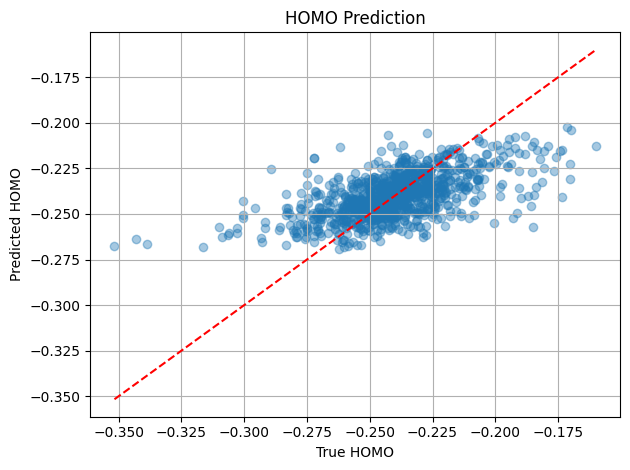

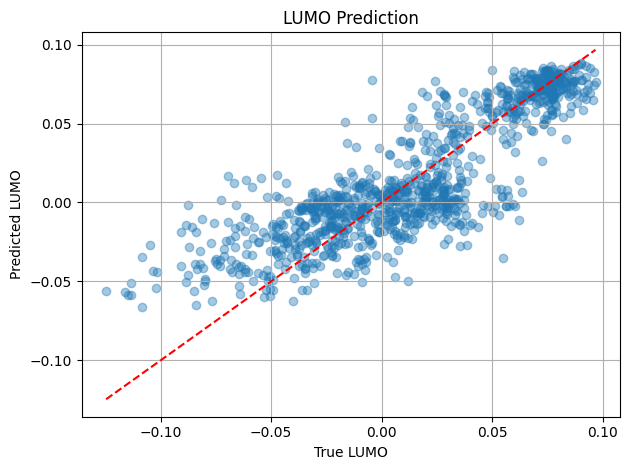

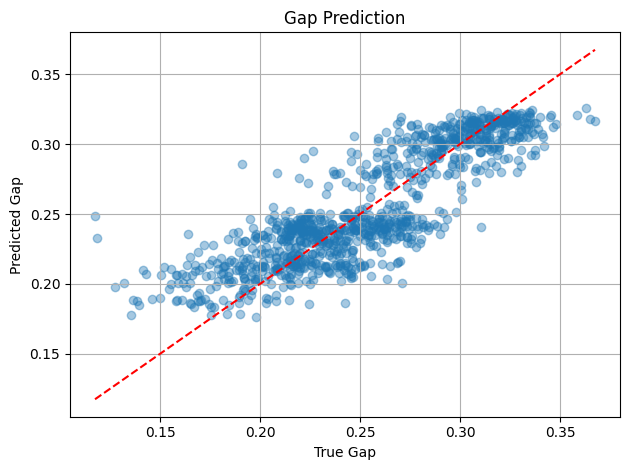

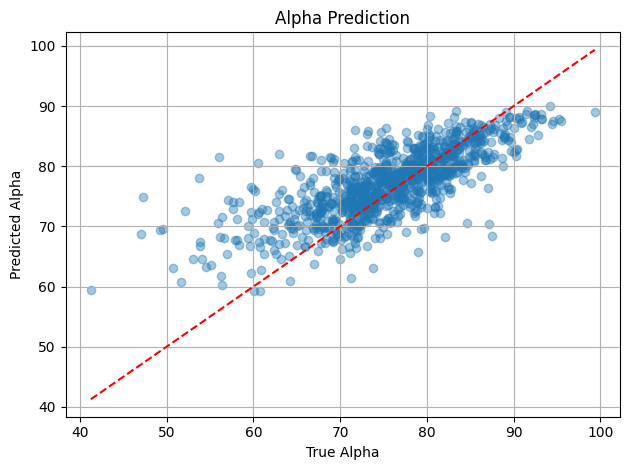

In [ ]:
import matplotlib.pyplot as plt

model.eval()
preds, truths = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x)
        preds.append(pred.cpu())
        truths.append(y)

preds = torch.cat(preds).numpy()
truths = torch.cat(truths).numpy()

# Inverse transform targets
preds = scaler.inverse_transform(preds)
truths = scaler.inverse_transform(truths)

# Plot
labels = ["HOMO", "LUMO", "Gap", "Alpha"]
for i in range(4):
    plt.figure()
    plt.scatter(truths[:, i], preds[:, i], alpha=0.4)
    plt.xlabel(f"True {labels[i]}")
    plt.ylabel(f"Predicted {labels[i]}")
    plt.title(f"{labels[i]} Prediction")
    plt.plot([truths[:, i].min(), truths[:, i].max()],
             [truths[:, i].min(), truths[:, i].max()], 'r--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Autoregressive Transformer

In [ ]:
df = pd.read_csv("datasets/qm9_.csv")
df = df.dropna(subset=["homo", "lumo", "gap", "alpha"])

# Filter top 5% for gap and alpha
df = df[(df["gap"] >= df["gap"].quantile(0.90)) & (df["alpha"] >= df["alpha"].quantile(0.90))].reset_index(drop=True)

# Normalize property vectors
scaler = StandardScaler()
props = scaler.fit_transform(df[["homo", "lumo", "gap", "alpha"]].values)
smiles_list = df["smiles"].tolist()

In [ ]:
class SMILESTokenizer:
    def __init__(self, smiles_list):
        chars = sorted(set("".join(smiles_list)))
        self.vocab = {c: i + 4 for i, c in enumerate(chars)}
        self.vocab["<pad>"] = 0
        self.vocab["<bos>"] = 1
        self.vocab["<eos>"] = 2
        self.vocab["<unk>"] = 3
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, s, max_len):
        tokens = [self.vocab["<bos>"]] + [self.vocab.get(c, self.vocab["<unk>"]) for c in s] + [self.vocab["<eos>"]]
        tokens += [self.vocab["<pad>"]] * (max_len - len(tokens))
        return torch.tensor(tokens[:max_len], dtype=torch.long)

    def vocab_size(self):
        return len(self.vocab)

In [ ]:
from torch.utils.data import Dataset

class PropertyToSMILESDataset(Dataset):
    def __init__(self, smiles_list, prop_vecs, tokenizer, max_len=128):
        self.smiles_list = smiles_list
        self.prop_vecs = prop_vecs
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        y = self.tokenizer.encode(self.smiles_list[idx], self.max_len)
        x = torch.tensor(self.prop_vecs[idx], dtype=torch.float32)
        return x, y[:-1], y[1:]

In [ ]:
import torch.nn as nn
import torch

class AutoregressiveTransformer(nn.Module):
    def __init__(self, vocab_size, seq_len=128, dim=256, heads=8, ff_mult=4, depth=6):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, 8)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, 8))
        self.prop_proj = nn.Linear(4, 8)
        self.cross_attn_proj = nn.Linear(8, dim)
        self.input_proj = nn.Linear(8, dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=ff_mult * dim,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=depth)
        self.out = nn.Linear(dim, vocab_size)

    def forward(self, props, tokens):
        B, T = tokens.shape
        token_embed = self.token_embed(tokens) + self.pos_embed[:, :T, :]
        tgt = self.input_proj(token_embed)
        props_embed = self.prop_proj(props).unsqueeze(1).repeat(1, T, 1)
        memory = self.cross_attn_proj(props_embed)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(tokens.device)
        out = self.decoder(tgt, memory, tgt_mask=tgt_mask)
        return self.out(out)

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = SMILESTokenizer(smiles_list)
dataset = PropertyToSMILESDataset(smiles_list, props, tokenizer)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = AutoregressiveTransformer(vocab_size=tokenizer.vocab_size()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.vocab["<pad>"])

for epoch in range(10):
    model.train()
    total_loss = 0
    for prop, input_seq, target_seq in loader:
        prop, input_seq, target_seq = prop.to(device), input_seq.to(device), target_seq.to(device)
        logits = model(prop, input_seq)
        loss = loss_fn(logits.view(-1, logits.size(-1)), target_seq.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(loader):.4f}")

Epoch 1: Loss = 1.4079
Epoch 2: Loss = 0.9980
Epoch 3: Loss = 0.8797
Epoch 4: Loss = 0.8193
Epoch 5: Loss = 0.7803
Epoch 6: Loss = 0.7473
Epoch 7: Loss = 0.7264
Epoch 8: Loss = 0.7043
Epoch 9: Loss = 0.6890
Epoch 10: Loss = 0.6718


In [ ]:
def sample_smiles(model, prop_vec, tokenizer, max_len=128):
    model.eval()
    prop = torch.tensor(prop_vec, dtype=torch.float32).unsqueeze(0).to(device)
    input_ids = torch.tensor([[tokenizer.vocab["<bos>"]]], dtype=torch.long).to(device)

    for _ in range(max_len - 1):
        with torch.no_grad():
            logits = model(prop, input_ids)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        input_ids = torch.cat([input_ids, next_token], dim=1)
        if next_token.item() == tokenizer.vocab["<eos>"]:
            break

    return ''.join(tokenizer.inv_vocab[idx.item()] for idx in input_ids[0][1:-1])

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

In [ ]:
def is_valid_smiles(smiles):
    return Chem.MolFromSmiles(smiles) is not None

def visualize_smiles(smiles: str, size=(300, 300)):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Draw.MolToImage(mol, size=size)
    else:
        print(f"Invalid SMILES: {smiles}")
        return None

In [ ]:
import random

def generate_structured_lists(n):
    result = []
    for _ in range(n):
        val1 = random.uniform(-0.4, 0.0)
        val2 = random.uniform(0.0, 0.5)
        difference = val2 - val1
        val4 = random.uniform(5, 30)
        result.append([val1, val2, difference, val4])
    return result

target_props_list = generate_structured_lists(12)
target_props = [ -0.1, 0.2, 0.3, 13]  # Homo, Lumo, Gap, Alpha
target_props_normalized = scaler.transform([[-1, 2, 3, 6]])
# target_props_normalized = scaler.transform(target_props_list[i]) for i in range(len(target_props_list))
# target_props_normalized = scaler.transform([target_props])[0]

generated_smiles = sample_smiles(model, target_props_normalized[0], tokenizer)
img = visualize_smiles(generated_smiles)
img.show()

[[-47.02057034 173.52466759 194.68565103 -25.78810982]]
Invalid SMILES: 111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111


[20:36:27] SMILES Parse Error: syntax error while parsing: 111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
[20:36:27] SMILES Parse Error: check for mistakes around position 1:
[20:36:27] 11111111111111111111111111111111111111111
[20:36:27] ^
[20:36:27] SMILES Parse Error: Failed parsing SMILES '111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111' for input: '111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'


AttributeError: 'NoneType' object has no attribute 'show'

In [ ]:
def visualize_multiple_smiles(smiles_list, mols_per_row=4):
    mols = []
    valid_smiles = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            mols.append(mol)
            valid_smiles.append(s)

    print(f"Valid molecules: {len(mols)} / {len(smiles_list)}")

    if not mols:
        print("No valid molecules to visualize.")
        return None

    return Draw.MolsToGridImage(mols, molsPerRow=mols_per_row)

In [ ]:
from PIL import Image

# Generate N molecules from property vectors
generated_smiles_list = [sample_smiles(model, target_props_list[i], tokenizer) for i in range(len(target_props_list))]
grid_img = visualize_multiple_smiles(generated_smiles_list)

Valid molecules: 12 / 12


['CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

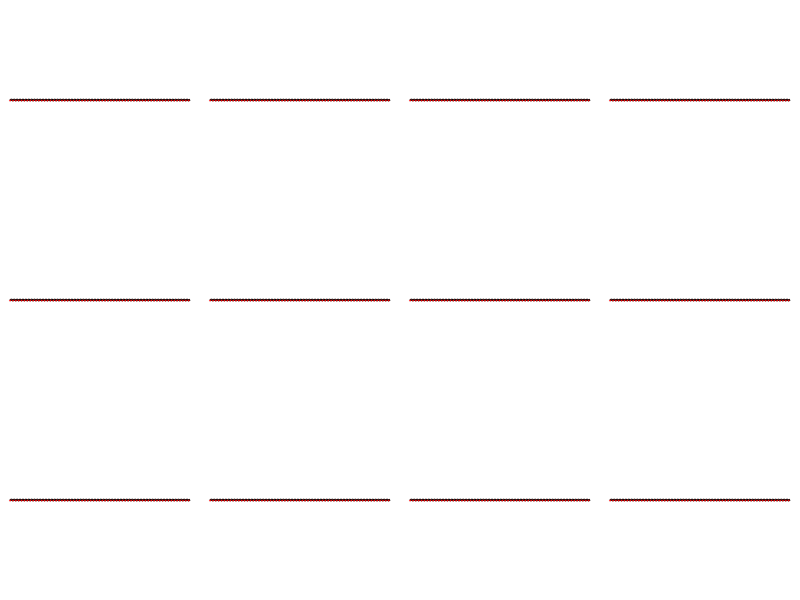

Grid image is not a valid image object.


In [ ]:
print(generated_smiles_list)
display(grid_img)

if grid_img:
    if isinstance(grid_img, Image.Image):  # Check if it's a PIL Image
        grid_img.show()
    else:
        print("Grid image is not a valid image object.")

Valid molecules: 1 / 1


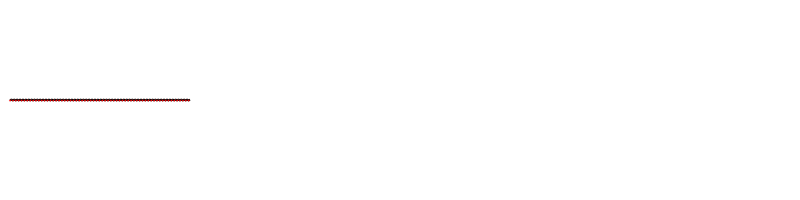

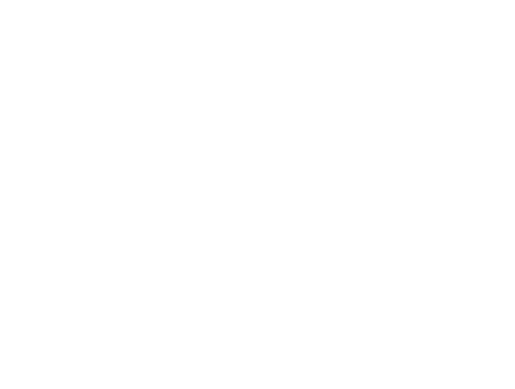

In [ ]:
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from PIL import Image

def visualize_multiple_smiles(smiles_list, mols_per_row=4):
    mols = []
    valid_smiles = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            mols.append(mol)
            valid_smiles.append(s)

    print(f"Valid molecules: {len(mols)} / {len(smiles_list)}")

    if not mols:
        print("No valid molecules to visualize.")
        return None

    # Create the grid image (this is already a PIL.Image object)
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row)

    return img

# Generate N molecules from property vectors
generated_smiles_list = [sample_smiles(model, target_props, tokenizer) for i in range(1)]
grid_img = visualize_multiple_smiles(generated_smiles_list)

if grid_img:
    # Display using matplotlib
    display(grid_img)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("No valid grid image to show.")